<a href="https://colab.research.google.com/github/LeaCarop/Deep_Learning/blob/main/Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**El primer paso para realizar la actividad es descargar el dataset desde una URL y descomprimir el archivo llamado Intel.** Una vez cargados los datos se observa una lista de salida con fotos pertenecientes a 6 tipos distintos de clases: *buildings, forest, glacier, mountain, sea y street*.

In [ ]:
!wget https://drive.upm.es/s/shvqhjNwmfdS6RS/download -O intel.zip
!unzip intel.zip
!rm intel.zip

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: __MACOSX/intel/validation/buildings/._20752.jpg  
  inflating: intel/validation/buildings/23529.jpg  
  inflating: __MACOSX/intel/validation/buildings/._23529.jpg  
  inflating: intel/validation/buildings/22637.jpg  
  inflating: __MACOSX/intel/validation/buildings/._22637.jpg  
  inflating: intel/validation/buildings/21470.jpg  
  inflating: __MACOSX/intel/validation/buildings/._21470.jpg  
  inflating: intel/validation/buildings/22031.jpg  
  inflating: __MACOSX/intel/validation/buildings/._22031.jpg  
  inflating: intel/validation/buildings/20140.jpg  
  inflating: __MACOSX/intel/validation/buildings/._20140.jpg  
  inflating: intel/validation/buildings/22025.jpg  
  inflating: __MACOSX/intel/validation/buildings/._22025.jpg  
  inflating: intel/validation/buildings/23475.jpg  
  inflating: __MACOSX/intel/validation/buildings/._23475.jpg  
  inflating: intel/validation/buildings/22596.jpg  
  inflating: __MACO

Antes de poner en marcha el algoritmo, he cargado todas aquellas librerías de Keras de TensorFlow y demás que creo pueda necesitar.


In [ ]:
import numpy as np
import os
import re
import sys
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator    # para preprocesar imágenes que ayude a entrenar el algoritmo
from tensorflow.keras.models import Sequential                         # permite hacer redes neuronales secuenciales
from tensorflow.keras import optimizers                                # optimizador para entrenar el algoritmo
from tensorflow.keras.layers import Conv2D, MaxPooling2D               # importante para las capas en las que se hacen las convoluciones
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model

He dejado a continuación el primer modelo que creé para la red neuronal para que se pueda apreciar la representación de la red gráficamente, pero no es este el modelo que utilizaré (aunque sí su estructura). 
Como vemos, mi idea es crear una una red neuronal convolucional con dos capas de convolución distintas acompañadas de dos capas de MaxPooling. Puede que también pruebe como sería el modelo si uso varias capas de una misma convolución, y como dato, lo más probable es que tenga mejores resultados de los que pueda obtener con dos. 

Para más adelante, como estamos clasificando imágenes la función de coste será la entropía cruzada (que es simplemente la suma de los productos de todas las probabilidades reales con el logaritmo negativo de las probabilidades predichas) y, teniendo en cuenta que el modo de clase (class_mode) es categórico (6 clases), la función de activación es softmax (que devuelve la distribución de probabilidad de cada una de las clases soportadas en el modelo). 

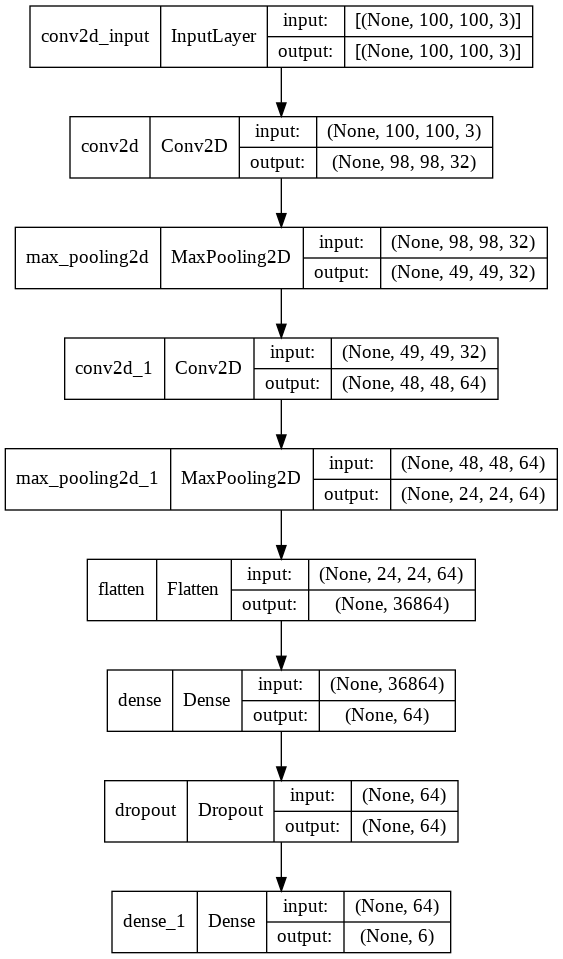

In [ ]:
def create_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (2, 2), activation='relu'))    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten()) 
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(6, activation='softmax'))

    return model
plot_model(create_model(), show_layer_names=True, show_shapes=True)


Para cargar las imágenes la mejor opción es usar un generador de datos (DataGenerator) de Keras que permite cargar las imágenes bajo demanda (sin afectar la memoria RAM) y, además, permite hacer Data Augmentation.

Con el uso de Data Augmentation se obtendrán modificaciones de una img, es decir, algunas tendrán rotaciones, efecto espejo o zoom. Esto nos ayuda para un mejor entrenamiento del modelo, así la máquina aprende que las figuras (sea perro, casa, humano, flor, etc) no serán estáticas. 

El siguiente bloque de código define los parámetros a utilizar para crear la red neuronal de dos capas y posteriormente, realizo el preprocesamiento creando dos ImagenDataGenerator y dos generadores, para las img de entrenamiento y de validación.

In [ ]:
K.clear_session()
data_entrenamiento = 'intel/train'        # lo he llamado así pero viene siendo nuestro x_train/y_train
data_validacion = 'intel/validation'      # x_test/y_test

# PARÁMETROS de la red neuronal con 2 CAPAS

epoch = 20                    # número de veces que se va a iterar sobre los datos durante el entrenamiento
altura, longitud = 100, 100   # tamaño al que se procesan las imágenes (100 px x 100 px)
batch_size = 180              # número de imágenes que se manda al ordenador a procesar en cada uno de los pasos
filtrosConv1 = 32             # después de la 1ra convolución la imagen va a tener una profundidad de 32
filtrosConv2 = 64             # después de la 2da convolución la imagen tiene una profundidsd de 64
tamano_filtro1 = (3, 3)       # para la 1ra convolucion tiene una altura y longitud de 3
tamano_filtro2 = (2,2)        # para la 2da convolución tiene una altura y longitud de 2
tamano_pool = (2,2)           # tamaño del filtro que se va a usar en el MaxPooling
clases = 6                    # buildings, forest, glacier, mountain, sea y street
lr = 0.0005                   # (learning_rate) qué tan grande van a ser los ajustes que hace la red neuronal para una solución óptima


# PRE-PROCESAMIENTO DE IMÁGENES
train_datagen = ImageDataGenerator(
    rescale=1./255,           # valores de 0 a 1  
    shear_range=0.3,          # inclina algunas imágenes
    zoom_range=0.3,           # hace zoom a algunas imágenes para que el algoritmo aprenda mejor
    horizontal_flip=True      # para distinguir direccionalidad (invierte la imagen) 
)

validation_datagen = ImageDataGenerator(
    rescale=1./255            # en validación solo se hace rescalado porque queremos dar la img tal cual es (original)
)

img_train = train_datagen.flow_from_directory(
    data_entrenamiento,
    target_size=(altura, longitud),
    batch_size=batch_size,
    class_mode='categorical' 
    # con esto lo que conseguimos es que se entre al directorio donde se encuentra intel/train y se le apliquen a 
    # las imágenes durante el procesamiento las características aquí definidas 
)

img_validation = validation_datagen.flow_from_directory(
    data_validacion,
    target_size=(altura, longitud),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


**Una vez definidos los parámetros para la red Neuronal y realizado el pre-procesamiento de las imágenes, se crea la red neuronal convolucional (CNN), posteriormente, clasifico y optimizo**

In [ ]:
from tensorflow.python.keras.backend import dropout
from tensorflow.python.keras.layers.convolutional import Convolution2D

# Creo la CNN

cnn = Sequential()    # la red es secuencial, es decir, son varias capas apiladas entre ellas
cnn.add(Convolution2D(filtrosConv1, tamano_filtro1, padding='same', input_shape=(altura, longitud, 3), activation='relu')) 
# la primera capa va a ser una convolución con el número de filtros (=32) y tamaño de filtros (=3,3) definidos anteriormente. 
# Con input_shape se define la altura y longitud de las img en esta 1ra capa, ya definida (=100,100), con una función de activación 
# ReLU --> transforma los valores introducidos anulando los valores negativos y dejando los positivos tal y como entran
cnn.add(MaxPooling2D(pool_size=tamano_pool))   # después de la 1ra capa hay una capa de MaxPooling y su filtro va tener tamaño (=2,2) píxeles
cnn.add(Convolution2D(filtrosConv2, tamano_filtro2, padding='same', activation='relu'))   # la 2da capa va a ser una convolución con el 
# número de filtros (=64), tamaño de filtros (=2,2) y una función de activación ReLU
cnn.add(MaxPooling2D(pool_size=tamano_pool))   # ya tenemos una red neuronal con dos capas de convolución y dos de MaxPooling

# Empieza el proceso de CLASIFICACIÓN 

cnn.add(Flatten())   # lo que conseguimos es que la img que ahora es profunda pero pequeña sea plana, es decir, tenga solo 1D   
cnn.add(Dense(64,activation='relu'))  # estas neuronas (=64) están conectadas con la capa anterior donde se aplanó la información
cnn.add(Dropout(0.4))   # a la capa densa durante train se le van a "apagar" el 40% de las neuronas para evitar el sobreajuste. Si todo el 
# tiempo todas las neuronas están activas puede que la red aprenda un camino específico, pero de esta forma va a aprender caminos alternos
cnn.add(Dense(clases, activation='softmax'))  # esta última capa contiene las clases y la función softmax dice la probabilidad de que una 
# imagen sea de una clase u otra. El valor con la clase más alta es la clasificación correcta.

# para OPTIMIZAR

cnn.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=lr), metrics=['accuracy']) #durante train, la función de 
# pérdida (loss) verá qué tan bien o mal va el modelo, con un learning_rate = 0.0005 y usando la métrica para optimizar accuracy. Esta dirá el  
# % de qué tan bien está aprendiendo la red



In [ ]:
# para ENTRENAR

history = cnn.fit(img_train, epochs=epoch, validation_data=img_validation)   
# la red va a entrenar con las img de entrenamiento y validación ya procesadas en el paso anterior


Epoch 1/20
78/78 [==============================] - 215s 3s/step - loss: 1.4265 - accuracy: 0.4429 - val_loss: 1.1374 - val_accuracy: 0.5763
Epoch 2/20
78/78 [==============================] - 200s 3s/step - loss: 1.1325 - accuracy: 0.5710 - val_loss: 0.9087 - val_accuracy: 0.6743
Epoch 3/20
78/78 [==============================] - 197s 3s/step - loss: 1.0423 - accuracy: 0.6109 - val_loss: 0.8205 - val_accuracy: 0.7037
Epoch 4/20
78/78 [==============================] - 197s 3s/step - loss: 0.9653 - accuracy: 0.6421 - val_loss: 0.7854 - val_accuracy: 0.7210
Epoch 5/20
78/78 [==============================] - 198s 3s/step - loss: 0.9212 - accuracy: 0.6613 - val_loss: 0.7539 - val_accuracy: 0.7443
Epoch 6/20
78/78 [==============================] - 197s 3s/step - loss: 0.8921 - accuracy: 0.6736 - val_loss: 0.7495 - val_accuracy: 0.7433
Epoch 7/20
78/78 [==============================] - 201s 3s/step - loss: 0.8603 - accuracy: 0.6846 - val_loss: 0.8016 - val_accuracy: 0.7087
Epoch 8/20
78

Una vez realizado el entrenamiento voy a interpretar los valores obtenidos. Para hacer más visual estos resultados lo mejor es representarlos gráficamente en conjunto. Para ello, realizo dos gráficos, uno para la función de coste y otro para el accuracy. 

<Figure size 432x288 with 0 Axes>

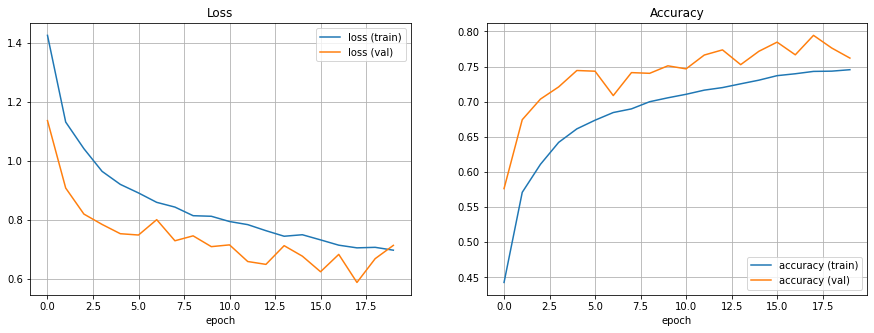

In [ ]:
fig = plt.figure()
plt.rcParams['figure.figsize'] = [15, 5]
f, (ax1, ax2) = plt.subplots(1, 2, sharex=True)
ax1.plot(history.history['loss'], label='loss (train)')
ax1.plot(history.history['val_loss'], label='loss (val)')
ax1.set_title('Loss')
ax1.set_xlabel('epoch')
ax1.legend(loc="upper right")
ax2.plot(history.history['accuracy'], label='accuracy (train)')
ax2.plot(history.history['val_accuracy'], label='accuracy (val)')
ax2.set_title('Accuracy')
ax2.set_xlabel('epoch')
ax2.legend(loc="lower right")
ax1.grid()
ax2.grid()
plt.show()


A simple vista podemos sacar puntos positivos y negativos tras el entrenamiento. 
Lo primero que podemos observar en ambos gráficos, es que la tendencia en validación y entrenamiento es similar. Para train y validation Loss disminuye, de manera más estable en train mientras val oscila. Numericamente, se consigue disminuir desde 1.42 a 0.69 y desde 1.13 a 0,71 en train y val respectivamente. Con respecto a la gráfica del Accuracy la precisión en el aprendizaje va aumentando con cada epoch que se entrena. Numericamente, se consigue una precisión que sube de un 44% a un 74% y de un 57% a un 76% en train y val respectivamente. 
Sin embargo, se observa un poco de overfitting (sobreajuste). No muy elevado, porque entiendo que para que sea un sobrejuste importante ambas líneas no deberían ir en dirección similar. En el último epoch se observa que ambas líneas se cruzan. Con un mayor número de epoch se puede observar que dirección toma Loss. 

Tal vez no sea el modelo ideal, pero cumple el requisito de tener un acuraccy > 1/6 y realiza las predicciones correctamente, como se ve a continuación. Posiblemente, reajustando los parámetros del modelo se obtenga un algoritmo más óptimo. 

**Una vez entrenado el modelo queda predecir imágenes para que nos diga su clase.**

In [ ]:
from tensorflow.python.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model 

def predict(file):   # creo la función predict que va a recibir el nombre de la imagen y responderá la clase correspondiente
  x = load_img(file, target_size=(altura, longitud))   # en x se carga la imagen a predecir
  x = img_to_array(x)           # para convertir en un arreglo la img --> x no es una img sino un arreglo de valores
  x = np.expand_dims(x, axis=0)   # en el eje 0 (1D) se quiere añadir una dimensión extra, para poder procesar la informacion sin problema
  arreglo= cnn.predict(x)     # llamo a la red diciendo que quiero hacer una predicción de x
  # arreglo lo que trae es un arreglo de 2D el cual tiene [[1,0,0]], lo que significa que el algoritmo piensa que '1' es la predicción 
  # correcta
  resultado= arreglo[0]  # el arreglo que devuelve cnn.predict es de 2D y solo nos interesa la 1D
  respuesta= np.argmax(resultado)   # respuesta trae un valor en dependencia de lo que devuelva resultado
  if respuesta==0:
    print('buildings')
  elif respuesta==1:
    print('forest')
  elif respuesta==2:
    print('glacier')
  elif respuesta==3:
    print('mountain')
  elif respuesta==4:
    print('sea')
  elif respuesta==5:
    print('street')
  

predict('intel/validation/sea/21507.jpg')
predict('intel/validation/buildings/23945.jpg')
predict('intel/validation/glacier/23884.jpg')
predict('intel/validation/street/20178.jpg')
predict('intel/validation/buildings/23446.jpg')
predict('intel/validation/mountain/22343.jpg')
predict('intel/validation/forest/20117.jpg')


sea
buildings
glacier
street
buildings
mountain
forest


Tras ver que el entrenamiento tiene un poco de sobreajuste, he comprobado con la función predict si la red ha aprendido las imágenes con las que ha entrendo. He comprobado con varias fotos al azar del dataset que, efectivamente, el algoritmo reconoce correctamente las imágenes de prueba.


Como comenté al principio de la libreta quería comprobar que resultados se alcanzaban en una red neuronal con varias capas de una sola convolución, manteniendo los mismos parámetros utilizados para crear la otra red.


In [ ]:
from tensorflow.python.keras.backend import dropout
from tensorflow.python.keras.layers.convolutional import Convolution2D

# Creo la CNN, CLASIFICO y OPTIMIZO 

cnn2 = Sequential()           
cnn2.add(Convolution2D(32, (3,3), padding='same', input_shape=(altura, longitud, 3), activation='relu')) 
cnn2.add(MaxPooling2D(pool_size=tamano_pool))      
cnn2.add(Convolution2D(64, (3,3), padding='same', activation='relu'))   
cnn2.add(MaxPooling2D(pool_size=tamano_pool))      
cnn2.add(Flatten())      
cnn2.add(Dense(64,activation='relu'))   
cnn2.add(Dropout(0.4))    
cnn2.add(Dense(clases, activation='softmax')) 
cnn2.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=lr), metrics=['accuracy'])



In [ ]:
# para ENTRENAR
history_2 = cnn2.fit(img_train, epochs=epoch, validation_data=img_validation) 

Epoch 1/20
78/78 [==============================] - 251s 3s/step - loss: 1.3726 - accuracy: 0.4372 - val_loss: 1.1639 - val_accuracy: 0.5813
Epoch 2/20
78/78 [==============================] - 248s 3s/step - loss: 1.0988 - accuracy: 0.5787 - val_loss: 1.0736 - val_accuracy: 0.5997
Epoch 3/20
78/78 [==============================] - 248s 3s/step - loss: 1.0132 - accuracy: 0.6201 - val_loss: 0.8572 - val_accuracy: 0.6873
Epoch 4/20
78/78 [==============================] - 249s 3s/step - loss: 0.9678 - accuracy: 0.6340 - val_loss: 0.8095 - val_accuracy: 0.7153
Epoch 5/20
78/78 [==============================] - 249s 3s/step - loss: 0.9253 - accuracy: 0.6536 - val_loss: 0.7574 - val_accuracy: 0.7357
Epoch 6/20
78/78 [==============================] - 247s 3s/step - loss: 0.9039 - accuracy: 0.6603 - val_loss: 0.7550 - val_accuracy: 0.7360
Epoch 7/20
78/78 [==============================] - 274s 4s/step - loss: 0.8412 - accuracy: 0.6881 - val_loss: 0.7931 - val_accuracy: 0.7353
Epoch 8/20
78

<Figure size 1080x360 with 0 Axes>

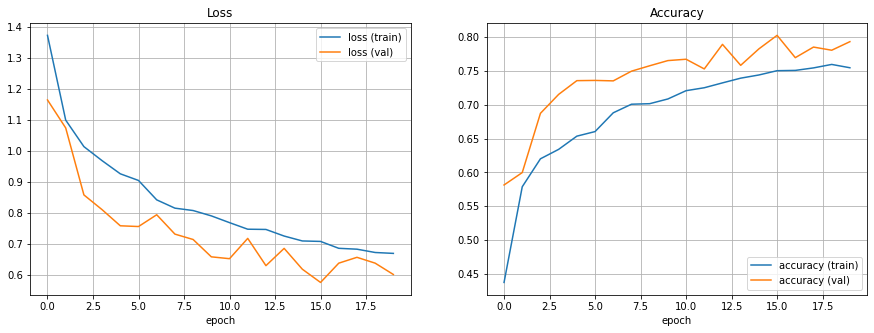

In [ ]:
fig = plt.figure()
plt.rcParams['figure.figsize'] = [15, 5]
f, (ax1, ax2) = plt.subplots(1, 2, sharex=True)
ax1.plot(history_2.history['loss'], label='loss (train)')
ax1.plot(history_2.history['val_loss'], label='loss (val)')
ax1.set_title('Loss')
ax1.set_xlabel('epoch')
ax1.legend(loc="upper right")
ax2.plot(history_2.history['accuracy'], label='accuracy (train)')
ax2.plot(history_2.history['val_accuracy'], label='accuracy (val)')
ax2.set_title('Accuracy')
ax2.set_xlabel('epoch')
ax2.legend(loc="lower right")
ax1.grid()
ax2.grid()
plt.show()


Como comentaba antes, los resultados obtenidos con la red neuronal de una convolución presenta unos resultados "un poco" mejores (no hay mucha diferencia) que el anterior modelo.
La tendencia en validación y entrenamiento sigue siendo similar. Numericamente, se consigue disminuir desde 1.37 a 0.66 y desde 1.16 a 0,60 en train y val respectivamente. Con respecto a la gráfica del Accuracy la precisión en el aprendizaje va aumentando con cada epoch que se entrena. Numericamente, se consigue una precisión que sube de un 43% a un 75% y de un 58% a un 79% en train y val respectivamente. 
Sin embargo, sigue presentando overfitting (sobreajuste), aunque menos elevado que en el modelo de dos convoluciones.

Finalmente, para poner en práctica el entrenamiento, he hecho uso de la función predict con imágenes distintas elegidas al azar y dichas img han sido clasificadas correctamente.

In [ ]:
from tensorflow.python.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model 

def predict(file):   # creo la función predict que va a recibir el nombre de la imagen y responderá la clase correspondiente
  y = load_img(file, target_size=(altura, longitud))   # en x se carga la imagen a predecir
  y = img_to_array(y)           # para convertir en un arreglo la img --> x no es una img sino un arreglo de valores
  y = np.expand_dims(y, axis=0)   # en el eje 0 (1D) se quiere añadir una dimensión extra, para poder procesar la informacion sin problema
  arreglo= cnn2.predict(y)     # llamo a la red diciendo que quiero hacer una predicción de x
  # arreglo lo que trae es un arreglo de 2D el cual tiene [[1,0,0]], lo que significa que el algoritmo piensa que '1' es la predicción 
  # correcta
  resultado= arreglo[0]  # el arreglo que devuelve cnn.predict es de 2D y solo nos interesa la 1D
  respuesta= np.argmax(resultado)   # respuesta trae un valor en dependencia de lo que devuelva resultado
  if respuesta==0:
    print('buildings')
  elif respuesta==1:
    print('forest')
  elif respuesta==2:
    print('glacier')
  elif respuesta==3:
    print('mountain')
  elif respuesta==4:
    print('sea')
  elif respuesta==5:
    print('street')
  

predict('intel/validation/buildings/22907.jpg')
predict('intel/validation/street/20221.jpg')
predict('intel/validation/glacier/23060.jpg')
predict('intel/validation/buildings/23446.jpg')
predict('intel/validation/sea/20595.jpg')
predict('intel/validation/forest/20056.jpg')
predict('intel/validation/mountain/20427.jpg')

buildings
street
glacier
buildings
sea
forest
mountain


**CONCLUSIÓN**

El algoritmo creado en este ejercicio no es totalmente válido, ya que a la hora de entrenar el modelo presenta overfitting. Seguramente el modelo funcionaría mejor si se ajustara algún parámetro, en el caso, de que (yo) no haya cometido ningún error a la hora de definir el modelo. 
Con el fin de comprobar el efecto que tiene sobre el algoritmo usar más de una convolución a la hora de crear la red neuronal, he decidido mostrar ambos ejemplos para comprobar los resultados. 
En el primer caso, la red neuronal con dos convoluciones presenta un poco más de overfitting y un poco menos de precisión que el modelo de red neuronal de una convolución. 
No obstante, el entrenamiento realizado en ambos casos ha valido para que el algoritmo clasifique correctamente las imágenes tras definir la función predict. Sin embargo, habría que comprobar si la clasificación es correcta una vez se añadan imágenes nuevas al dataset. 
